# TEST CNN

The idea is to use Convolution Neural Network to extract features of the framed specturm and classify the audio data.


## 1. Preprocessing

In [2]:
%matplotlib inline
import os
import re
from glob import glob

import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

from scipy.io import wavfile
import scipy
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import IPython.display as ipd

import tensorflow as tf


from sklearn.model_selection import train_test_split
from tensorflow.contrib.learn.python.learn.learn_io.generator_io import generator_input_fn

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from keras.optimizers import Adam
from scipy import signal

ImportError: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/usr/local/lib/python3.5/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/usr/local/lib/python3.5/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: libcublas.so.9.0: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [2]:
os.listdir('/audio_sample')

['validation_list.txt',
 'audio',
 '.DS_Store',
 'README.md',
 'LICENSE',
 'testing_list.txt']

In [3]:
DATA_PATH = '/audio_sample' # path to training data

In [4]:
folders = []
TRAIN_DATA_PATH = DATA_PATH+ '/audio/'
for file_folder in os.listdir(TRAIN_DATA_PATH):
    if os.path.isdir(TRAIN_DATA_PATH + file_folder):
        folders.append(file_folder)
print(folders)
print('There are totally ' + str(len(folders)) + ' labels in the training dataset.')

['up', 'dog', 'house', 'bird', 'left', 'go', 'five', 'off', 'eight', 'on', 'seven', 'down', '_background_noise_', 'right', 'four', 'three', 'nine', 'stop', 'bed', 'zero', 'happy', 'cat', 'tree', 'yes', 'wow', 'marvin', 'six', 'no', 'two', 'sheila', 'one']
There are totally 31 labels in the training dataset.


However, from the competition note, there are only 12 labels we have to pay attention to.
> **Note**: There are only 12 possible labels for the Test set: yes, no, up, down, left, right, on, off, stop, go, silence, unknown.

> The unknown label should be used for a command that is not one one of the first 10 labels or that is not silence.

In [5]:
POSSIBLE_LABELS = 'yes, no, up, down, left, right, on, off, stop, go, silence, unknown'.replace(' ', '').split(',')
print(POSSIBLE_LABELS)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown']


 The file *validation_list.txt* specifies the data for validation.

In [6]:
VALIDATION_LIST_FILE_PATH = DATA_PATH + '/validation_list.txt'
with open(VALIDATION_LIST_FILE_PATH, 'r') as file:
    VALIDATION_FILE_NAMES = [line.rstrip() for line in file]

TEST_LIST_FILE_PATH = DATA_PATH + '/testing_list.txt'
with open(TEST_LIST_FILE_PATH, 'r') as file:
    TEST_FILE_NAMES = [line.rstrip() for line in file]


In [7]:
sample_matcher = re.compile("(?:.+\/)?(\w+)\/([^_]+)_.+wav")
def get_info_from_path(path):
    """
        return (label, id)
    """
    r = sample_matcher.match(path)
    if not r:
        raise ValueError(path + ' is not valid file path')
    label = r.group(1)
    id = r.group(2)
    
    if label not in POSSIBLE_LABELS:
        if label == '_background_noise_':
            label = 'silence'
        else:
            label = 'unknown'
    return label, id

In [8]:
VALIDATION_FILES = []
VALIDATIN_ID_SET = {}
for file in VALIDATION_FILE_NAMES:
    try: 
        label, id = get_info_from_path(file)
    except ValueError as e:
        print(e)
        continue
    VALIDATION_FILES.append((label, id, file))
    VALIDATIN_ID_SET[id] = True

TEST_FILES = []
TEST_ID_SET = {}
for file in TEST_FILE_NAMES:
    try: 
        label, id = get_info_from_path(file)
    except ValueError as e:
        print(e)
        continue
    TEST_FILES.append((label, id, file))
    TEST_ID_SET[id] = True

In [9]:
# train file is the file that neither in test or validation
file_path_matcher = re.compile("(.+\/)?(\w+\/[^_]+_.+wav)")
TRAIN_FILES = []
SAMPLE_FILES = glob(os.path.join(DATA_PATH, 'audio/*/*wav'))
for file in SAMPLE_FILES:
    try:
        label, id = get_info_from_path(file)
    except ValueError as e:
        print(e)
        continue
    if not id in VALIDATIN_ID_SET and not id in TEST_ID_SET:
        TRAIN_FILES.append((label, id, file_path_matcher.match(file).group(2)))

In [10]:
print('Number of sample')
print('Total: %d' % len(SAMPLE_FILES))
print('Train: %d' % len(TRAIN_FILES))
print('Validation: %d' % len(VALIDATION_FILES))
print('Test: %d' % len(TEST_FILES))
number_sum = len(TRAIN_FILES) + len(VALIDATION_FILES) + len(TEST_FILES)
print('{} + {} + {} = {}'.format(len(TRAIN_FILES), len(VALIDATION_FILES), len(TEST_FILES), number_sum))

Number of sample
Total: 64727
Train: 51094
Validation: 6798
Test: 6835
51094 + 6798 + 6835 = 64727


### look at the data

#### a. distribution

In [11]:
distribution = {}
for label, _, _ in TRAIN_FILES + VALIDATION_FILES:
    if label not in distribution:
        distribution[label] = 0
    distribution[label] = distribution[label] + 1

data = [go.Bar(
            x=[*distribution.keys()],
            y=[*distribution.values()]
    )]

py.iplot(data, filename='distribution')

When we look at the distribution of the data, **unknwon**, **silence** are two special labels. **unknown** has much more data than others, **silence** only has 6.


Ideas to handle the two special cases:
- train a model to seperate **silence** from the rest. Then we train another one to seperate **unknown** from the key words that we are interesting.

- bootstrap the other types

- throw away some of unknown words

In [12]:
distribution = {}
for label, _, _ in VALIDATION_FILES:
    if label not in distribution:
        distribution[label] = 0
    distribution[label] = distribution[label] + 1

data = [go.Bar(
            x=[*distribution.keys()],
            y=[*distribution.values()]
    )]

py.iplot(data, filename='distribution')

The wierd thing is that validation set does not have **silence**. So in order to train the silence detect model, I have to use the train set for both training and validation

#### b. audio length

In [11]:
sample_length_list = []

# read in every audio and count each length
for label, id, file in TRAIN_FILES + VALIDATION_FILES:
    sample_rate, samples = wavfile.read(TRAIN_DATA_PATH + file)
    sample_length_list.append(len(samples))

/usr/local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.



In [12]:
sample_rate = 16000
sample_length_list = np.array(sample_length_list)
sample_length_list[sample_length_list > sample_rate]

array([ 960000,  978488,  980062, 1522930,  960000,  988891])

In [13]:
train_valid_files = np.array(TRAIN_FILES + VALIDATION_FILES)
large_audio_files = train_valid_files[sample_length_list > sample_rate]
print(large_audio_files)

[['silence' 'white' '_background_noise_/white_noise.wav']
 ['silence' 'running' '_background_noise_/running_tap.wav']
 ['silence' 'exercise' '_background_noise_/exercise_bike.wav']
 ['silence' 'doing' '_background_noise_/doing_the_dishes.wav']
 ['silence' 'pink' '_background_noise_/pink_noise.wav']
 ['silence' 'dude' '_background_noise_/dude_miaowing.wav']]


There are some really long audio. Hopefully, there are not too much and they are those background noise. Let's hear some of them.

In [14]:
ipd.Audio(filename=TRAIN_DATA_PATH + large_audio_files[4][2])

**Some ideas to handle it:**
- chop the long file into 1 second length
- mix different types of noise
- mix noise with audio file

In [15]:
sample_rate = 16000
sample_length_list = np.array(sample_length_list)
sample_length_list[sample_length_list < 0.5 * sample_rate]

array([7510, 7431, 7851, 7431, 6688, 7339, 7510, 7431, 7431, 6688, 7431,
       5945, 7431, 7339, 6827, 6688, 6688, 7431, 7510, 7431, 7431, 6827,
       7431, 7431, 6827, 7510, 6144, 6827, 6827, 6827, 7510])

There are some very short audio. Also not too much.

(array([  3.10000000e+01,   2.87000000e+02,   9.59000000e+02,
          1.62200000e+03,   5.49870000e+04]),
 array([  5945.,   7956.,   9967.,  11978.,  13989.,  16000.]),
 <a list of 5 Patch objects>)

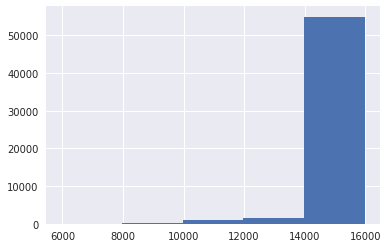

In [16]:
truncated_sample_length = sample_length_list[sample_length_list <= 3 * sample_rate]
plt.hist(truncated_sample_length, 5)

In [17]:
small_sample_num = len(sample_length_list[sample_length_list < sample_rate])
print('There are about %d samples smaller than the sample rate' % small_sample_num)

There are about 5865 samples smaller than the sample rate


**Some idea to handle short audio sample:**
- padding 0 to it
- stretch the audio to 1 seconds
- decompose it into phonome

In [18]:
def pad_to_middle(sample, sample_rate=16000):
    pad_num = sample_rate - len(sample)
    left = int(pad_num / 2)
    right = pad_num - left
    return np.pad(sample, (left, right), 'constant')

In [19]:
def chop_data(sample, sample_rate=16000):
    num = np.ceil(len(sample) / sample_rate).astype(np.int)
    pad_num = num * sample_rate - len(sample)
    return np.split(np.pad(sample, (0, pad_num), 'constant'), num)

In [20]:
def random_select(sample, sample_rate=16000):
    beg = np.random.randint(0, len(sample) - sample_rate)
    return sample[beg: beg + sample_rate]

In [21]:
def get_label(label):
    if label == 'silence':
        return 1
    return 0

In [22]:
data_list = []

# read file into memoery
if len(data_list) < 1:
    for label, id, fname in TRAIN_FILES:
        sample_rate, sample = wavfile.read(TRAIN_DATA_PATH + fname)
        data_list.append((label, id, sample))

/usr/local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.



In [23]:
# extract the long silence samples
silence_samples = list(filter(lambda t: t[0] == 'silence', data_list))
non_silence_samples = list(filter(lambda t: t[0] != 'silence', data_list))

In [25]:
SLICED_SILENCE_FILES_PATH = os.path.join('./', 'augumented_data/short_silence/')

# problem here, generate the training, validation from the same source is invalid
for i in range(len(non_silence_samples)):
    index = np.random.randint(0, len(silence_samples))
    if len(silence_samples[index][2]) < 16000:
        print(silence_samples[i])
    random_sample = random_select(silence_samples[index][2], 16000)
    title = silence_samples[index][0]
    file_name = title + '_' + str(index) + '_' + str(i) + '.wav'
    wavfile.write(os.path.join(SLICED_SILENCE_FILES_PATH, file_name), 16000, random_sample)

In [24]:
SLICED_SILENCE_FILES = []
SLICED_SILENCE_FILES_PATHS = glob(os.path.join('./', 'augumented_data/short_silence/*wav'))

short_silence_samples =[]

for file in SLICED_SILENCE_FILES_PATHS:
    _, sample = wavfile.read(file)
    r = sample_matcher.match(file)
    short_silence_samples.append(('silence', r.group(2), sample))

In [25]:
no_silence_train_data_list = []

for label, id, sample in data_list:
    if label != 'silence':
        no_silence_train_data_list.append((label, id, sample))

In [26]:
silence_data_train, silence_data_valid = train_test_split(
    short_silence_samples, test_size=len(VALIDATION_FILES)/len(TRAIN_FILES), random_state=42)

In [27]:
valid_data_list = []

if len(valid_data_list) < 1:
    for label, id, fname in VALIDATION_FILES:
        sample_rate, sample = wavfile.read(TRAIN_DATA_PATH + fname)
        valid_data_list.append((label, id, sample))

In [28]:
silence_model_train_data = no_silence_train_data_list + silence_data_train
silence_model_valid_data = valid_data_list + silence_data_valid

In [31]:
def silence_train_input_genetator(data_list=silence_model_train_data, sample_rate=16000):
    """
    To train the model to detect silence.
    For silence data we have to find some
    way to geneate some in order to handle
    the misbalance problem.
    """

    np.random.shuffle(silence_model_train_data)
    def generator():
        for label, id, sample in data_list:
            try:
                sample = sample.astype(np.float32) / np.iinfo(np.int16).max
                if len(sample) < sample_rate:
                    samples = [pad_to_middle(sample)]
                elif len(sample) > sample_rate:
                    samples = chop_data(sample)
                else:
                    samples = [sample]
                for one_second_sample in samples:
                    yield dict(
                        target=np.int32(get_label(label)),
                        wav=one_second_sample
                    )
            except Exception as err:
                print(err, label, id, fname)

    
    return generator

In [32]:
def silence_eval_input_genetator(data_list=silence_model_valid_data, sample_rate=16000):
    """
    To train the model to detect silence.
    For silence data we have to find some
    way to geneate some in order to handle
    the misbalance problem.
    """
    def generator():
        for label, id, sample in data_list:
            try:
                sample = sample.astype(np.float32) / np.iinfo(np.int16).max
                if len(sample) < sample_rate:
                    samples = [pad_to_middle(sample)]
                elif len(sample) > sample_rate:
                    samples = [chop_data(sample)[0]]
                else:
                    samples = [sample]
                for one_second_sample in samples:
                    yield dict(
                        target=np.int32(get_label(label)),
                        wav=one_second_sample
                    )
            except Exception as err:
                print(err, label, id, fname)

    
    return generator


## 2. CNN with spectrum
The idea is to chop the audio data into different frame. Take the frequency info from each frame and put those into CNN. As mentioned before, the plan is to build 3 models: detect silence, detect unkown, classify the data. And combine them finally.

**a. the first model is to detect the silence**

In [59]:
from tensorflow.contrib import layers, signal
def silence_model_handler(features, labels, mode, params, config):
    
    ### ================ Define the CNN ==========================
    sample = features['wav']
    is_training = mode == tf.estimator.ModeKeys.TRAIN
    x = tf.abs(signal.stft(sample, 400, 160))
    x = tf.stack([x], axis=3)
    x = tf.to_float(x)
    x = layers.batch_norm(x, is_training=is_training)
    for i in range(3):
        x = layers.conv2d(
            x, 8 * (2 ** i), 3, 1,
            normalizer_fn=layers.batch_norm,
            normalizer_params={'is_training': is_training}
        )
        x = layers.max_pool2d(x, 2, 2)
    x = layers.flatten(x)
    x = tf.layers.dense(x, 128, activation=tf.nn.relu)
    x = layers.dropout(x, keep_prob=params['keep_prob'] if is_training else 1.0)
    x = tf.layers.dense(x, 64, activation=tf.nn.relu)
    logits = tf.layers.dense(x, 2, activation=None)

    ### ===========================================================
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
        train_op=layers.optimize_loss(
            loss=loss,
            global_step=tf.train.get_global_step(),
            learning_rate=0.001,
            optimizer=tf.train.AdamOptimizer
        )
        
        specs = {'mode': mode, 'loss': loss, 'train_op': train_op}
    
    if mode == tf.estimator.ModeKeys.EVAL:
        prediction = tf.argmax(logits, axis=-1)
        acc, acc_op = tf.metrics.mean_per_class_accuracy(
            labels, prediction, 2)
        loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
        specs = dict(
                mode=mode,
                loss=loss,
                eval_metric_ops=dict(
                    acc=(acc, acc_op),
                )
        )
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'label': tf.argmax(logits, axis=-1),  
            'sample': features['wav'], 
        }
        specs = {
            'mode': mode,
            'predictions': predictions,
        }
    return tf.estimator.EstimatorSpec(**specs)

In [60]:
OUT_PATH = os.path.join('./', 'out')
os.makedirs(OUT_PATH, exist_ok=True)
params = {
    'keep_prob': True
}
run_config = tf.contrib.learn.RunConfig(
    model_dir=OUT_PATH, 
    log_step_count_steps=10,
    save_summary_steps=10
)

In [61]:
silence_model = tf.estimator.Estimator(
    model_fn=silence_model_handler, params=params, config=run_config)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa0b8db7438>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_secs': 600, '_log_step_count_steps': 10, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': './out'}


In [62]:
# silence_model_input_fn = silence_train_input_from_memory(silence_model_train_data)
silence_model_input_fn = generator_input_fn(
    x=silence_train_input_genetator(silence_model_train_data),
    target_key='target',
    shuffle=True,
    num_epochs=None,
    batch_size=50,
    queue_capacity=3 * 50 + 10, num_threads=1,
)


In [69]:
# train_input = lambda: silence_train_input_from_memory(data_list)
silence_model.train(input_fn=silence_model_input_fn, steps=300)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./out/model.ckpt-600
INFO:tensorflow:Saving checkpoints for 601 into ./out/model.ckpt.
INFO:tensorflow:loss = 0.00682011, step = 601
INFO:tensorflow:global_step/sec: 37.576
INFO:tensorflow:global_step/sec: 58.2473
INFO:tensorflow:global_step/sec: 58.8414
INFO:tensorflow:global_step/sec: 59.1577
INFO:tensorflow:global_step/sec: 59.5126
INFO:tensorflow:global_step/sec: 59.1602
INFO:tensorflow:global_step/sec: 59.1187
INFO:tensorflow:global_step/sec: 57.71
INFO:tensorflow:global_step/sec: 58.875
INFO:tensorflow:global_step/sec: 59.169
INFO:tensorflow:loss = 0.0125222, step = 701 (1.796 sec)
INFO:tensorflow:global_step/sec: 58.1213
INFO:tensorflow:global_step/sec: 57.7284
INFO:tensorflow:global_step/sec: 58.1026
INFO:tensorflow:global_step/sec: 58.893
INFO:tensorflow:global_step/sec: 59.0424
INFO:tensorflow:global_step/sec: 58.6086
INFO:tensorflow:global_step/sec: 59.2992
INFO:tensorflow:global_step/sec: 

In [70]:
silence_model_eval_input_fn = generator_input_fn(
    x=silence_eval_input_genetator(silence_model_valid_data),
    target_key='target'
)

In [71]:
silence_model.evaluate(input_fn=silence_model_eval_input_fn)

INFO:tensorflow:Starting evaluation at 2018-03-29-08:55:16
INFO:tensorflow:Restoring parameters from ./out/model.ckpt-900
INFO:tensorflow:Finished evaluation at 2018-03-29-08:55:17
INFO:tensorflow:Saving dict for global step 900: acc = 0.988513, global_step = 900, loss = 0.0426568


{'acc': 0.98851252, 'global_step': 900, 'loss': 0.042656817}

The Estimator from tensorflow is not very developer friendly, hard to learn and also need a lot of redundancy codes. So I switch to keras which is very friendly

In [33]:
silence_model = Sequential()
silence_model.add(BatchNormalization(input_shape=(99, 161,1)))
silence_model.add(Conv2D(32, (3, 3), activation='relu'))
silence_model.add(Conv2D(32, (3, 3), activation='relu'))
silence_model.add(MaxPooling2D(pool_size=(2, 2)))
silence_model.add(BatchNormalization())

silence_model.add(Conv2D(64, (3, 3), activation='relu'))
silence_model.add(Conv2D(64, (3, 3), activation='relu'))
silence_model.add(MaxPooling2D(pool_size=(2, 2)))
silence_model.add(BatchNormalization())

silence_model.add(Conv2D(256, (3, 3), activation='relu'))
silence_model.add(Conv2D(256, (3, 3), activation='relu'))
silence_model.add(MaxPooling2D(pool_size=(2, 2)))
silence_model.add(BatchNormalization())

silence_model.add(Conv2D(512, (3, 3), activation='relu'))
silence_model.add(Conv2D(512, (3, 3), activation='relu'))
silence_model.add(MaxPooling2D(pool_size=(2, 2)))
silence_model.add(BatchNormalization())
silence_model.add(Dropout(0.25))

silence_model.add(Flatten())
silence_model.add(Dense(256, activation='relu'))
silence_model.add(Dropout(0.5))
silence_model.add(Dense(128, activation='relu'))
silence_model.add(Dropout(0.5))
silence_model.add(Dense(2, activation='softmax'))

adam = Adam(lr=1e-5)
silence_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])

In [31]:
def log_specgram(audio, sample_rate=16000, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = scipy.signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return np.log(spec.T.astype(np.float32) + eps)

In [29]:
np.random.shuffle(silence_model_train_data)
np.random.shuffle(silence_model_valid_data)
silence_model_train_data_x = list(map(lambda t: t[2], silence_model_train_data))
silence_model_train_data_y = list(map(lambda t: 1 if t[0] == 'silence' else 0, silence_model_train_data))
silence_model_train_data_y = keras.utils.to_categorical(silence_model_train_data_y, num_classes=2)
silence_model_valid_data_x = list(map(lambda t: t[2], silence_model_valid_data))
silence_model_valid_data_y = list(map(lambda t: 1 if t[0] == 'silence' else 0, silence_model_valid_data))
silence_model_valid_data_y = keras.utils.to_categorical(silence_model_valid_data_y, num_classes=2)

In [32]:
silence_model_train_data_x_spectrum = list(map(pad_to_middle, silence_model_train_data_x))
silence_model_train_data_x_spectrum = np.stack(map(log_specgram, silence_model_train_data_x_spectrum))
silence_model_train_data_x_spectrum = np.array(silence_model_train_data_x_spectrum)
silence_model_train_data_x_spectrum = silence_model_train_data_x_spectrum.reshape(-1, 99, 161, 1)

In [33]:
silence_model_valid_data_x_spectrum = list(map(pad_to_middle, silence_model_valid_data_x))
silence_model_valid_data_x_spectrum = np.stack(map(log_specgram, silence_model_valid_data_x_spectrum))
silence_model_valid_data_x_spectrum = np.array(silence_model_valid_data_x_spectrum)
silence_model_valid_data_x_spectrum = silence_model_valid_data_x_spectrum.reshape(-1, 99, 161, 1)

In [34]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('./', 'silence-checkpoint-{epoch:02d}-{acc:.2f}.hdf5'))

In [39]:
silence_model.fit(x=silence_model_train_data_x_spectrum, y=silence_model_train_data_y, 
                  batch_size=32, epochs=5, callbacks=[checkpoint],
                  validation_data=(silence_model_valid_data_x_spectrum, silence_model_valid_data_y)
                 )

Train on 95378 samples, validate on 13596 samples
Epoch 1/5
95378/95378 [==============================] - 97s - loss: 0.1525 - acc: 0.9451 - val_loss: 0.0163 - val_acc: 0.9961
Epoch 2/5
95378/95378 [==============================] - 94s - loss: 0.0360 - acc: 0.9882 - val_loss: 0.0045 - val_acc: 0.9987
Epoch 3/5
95378/95378 [==============================] - 95s - loss: 0.0134 - acc: 0.9959 - val_loss: 0.0015 - val_acc: 0.9999
Epoch 4/5
95378/95378 [==============================] - 94s - loss: 0.0058 - acc: 0.9985 - val_loss: 3.8460e-04 - val_acc: 0.9999
Epoch 5/5
95378/95378 [==============================] - 94s - loss: 0.0031 - acc: 0.9991 - val_loss: 7.1781e-05 - val_acc: 1.0000


The result is very high. But consider the validation, training set comes from the same source. The model may overfitting.

** b. the second model is to detect unknown words**

In [35]:
non_silence_train_data = list(filter(lambda t: t[0] != 'silence', silence_model_train_data))
non_silence_valid_data = list(filter(lambda t: t[0] != 'silence', silence_model_valid_data))

In [36]:
np.random.shuffle(non_silence_train_data)

train_x = list(map(lambda t: t[2], non_silence_train_data))
train_x_equal_length = list(map(pad_to_middle, train_x))
train_x_spectrum = np.stack(map(log_specgram, train_x_equal_length))
train_x_spectrum = np.array(train_x_spectrum)
train_y = list(map(lambda t: 1 * (t[0] == 'unknown'), non_silence_train_data))

train_x_spectrum = train_x_spectrum.reshape(-1, 99, 161, 1)
train_y_one_hot = keras.utils.to_categorical(train_y, num_classes=2)

In [37]:
np.random.shuffle(non_silence_valid_data)

valid_x = list(map(lambda t: t[2], non_silence_valid_data))
valid_x_equal_length = list(map(pad_to_middle, valid_x))
valid_x_spectrum = np.stack(map(log_specgram, valid_x_equal_length))
valid_x_spectrum = np.array(valid_x_spectrum)
valid_y = list(map(lambda t: 1 * (t[0] == 'unknown'), non_silence_valid_data))

valid_x_spectrum = valid_x_spectrum.reshape(-1, 99, 161, 1)
valid_y_one_hot = keras.utils.to_categorical(valid_y, num_classes=2)

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=(99, 161,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(Conv2D(512, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

adam = Adam(lr=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(filepath=os.path.join(DATA_PATH, 'checkpoint-unknown-{epoch:02d}-{val_loss:.2f}.hdf5'))
model.fit(train_x_spectrum, train_y_one_hot, validation_data=(valid_x_spectrum, valid_y_one_hot), 
          batch_size=32, epochs=30, callbacks=[checkpoint])

Train on 51088 samples, validate on 6798 samples
Epoch 1/30


In [ ]:
if False:
    model.save('./unknown_model')